#Lecture 11: Data Augmentation and Slice Sampling

AM207: Pavlos Protopapas, Harvard University

March 4, 2014


------


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from scipy.stats import norm

import sys
from IPython import display

C:\Users\vkaynig\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


$$
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\corr}{{\rm corr}}
\newcommand{\xss}{x^{(i+1)}}
\newcommand{\xs}{x^{\star}}
\newcommand{\xt}{x^{(i)}}
\newcommand{\yss}{y^{(i+1)}}
\newcommand{\ys}{y^{\star}}
\newcommand{\yt}{y^{(i)}}
\newcommand{\xa}{x_a}
\newcommand{\xb}{x_b}
$$

# Data Augmentation

The term data augmentation refers to methods for constructing iterative algorithms via the introduction of unobserved data or latent variables. For deterministic algorithms, the method was popularized in the general statistical community by the seminal paper of Dempster, Laird, and Rubin (1977) on the EM algorithm for maximizing a likelihood function or more generally a posterior density. For stochastic algorithms, the method was popularized in the statistical literature by Tanner and Wong's (1987) *Data Augmentation algorithm for posterior sampling*, and in the physics literature by Swendsen and Wang's (1987) algorithm for sampling from Ising and Potts models and it generalizations; in the physics literature, the method of data augmentation is referred to as the method of auxiliary variables. Data augmentation schemes were used by Tanner and Wong to make simulation feasible and simple, while auxiliary variables were adopted by Swendsen and Wang to improve the speed of iterative simulation. In general, however, constructing data augmentation schemes that result in both simple and fast algorithms is a matter of art in that successful strategies vary greatly with the observed-data models being considered. 

Lets go back to our usual goal. Find the value of an integral 

$$  I=\int f(x) p(x) dx  $$

(and other integrals that use $p(x)$ as a pdf) which cannot be computed analytically. 

The basic idea is, if it is difficult to simulate from $p(x)$ using the traditional methods we've learned so far, it is often possible to find a joint pdf 
that:

$$ \int p(x,y)\, dy = p(x)  $$

and simulating from the associated conditional pdfs, $p(x|y)$ and $p(y|x)$ is easy.

The DA algorithm is based on this joint pdf, and we *marginalize* over the **augmenting variable** $y$ to obtain samples for $p(x)$.

The first property allows for a construction of Markov chain (see below for the proof). 


The simplest form of DA algorithm takes the following form:

1. Draw $Y\sim p_{Y|X}(.|x)$ and call the observed value y
2. Draw $X_{n+1} \sim p_{X|Y}(.|y)$  

The genesis of the name data augmentation algorithm appears to be Tanner and Wong
(1987) who used it to describe an iterative algorithm for approximating complex posterior
distributions. However, it does not appear to be the case
that Tanner and Wong (1987) ''invented'' the DA algorithm (as I have defined it here), since other researchers, such as Swendsen and Wang (1987) were using it at about the same time. 

Lets do one simple examples and then show the proof of Markov chain. 

## Examples

###Example 1

Suppose that $p_X$ is the standard normal density, i.e., $p(x) = e^{-x^2/2}/\sqrt{2\pi}$.
Obviously, there is nothing difficult about this density. Nevertheless, it is best to start with something simple in which the basic ideas of the algorithm are not overshadowed by the complexity of the target density. Take 

$$p(x, y) = 1/(\sqrt{2\pi}) \exp{\left\{-(x^2 - \sqrt{2} xy + y^2) \right\} } $$

which is a bivariate normal density with means equal to zero, variances equal
to one, and correlation equal to $1/\sqrt{2}$. The two conditionals are  normal, as we can see by completing the square and neglecting the part of the function that only depends on the variable not being conditioned upon ($e^{-y^2 }$ and $e^{-x^2 }$ respectively for the conditionals below).

$$ 
Y|X = x \, \, \sim N(x/\sqrt{2}, 1/2) \,\,\,  \rm{and} \,\,\, X|Y= y \,\,\sim N(y/\sqrt{2}, 1/2) $$

The x-marginal is 

$$\propto e^{-x^{2}/2} \int e^{-(y-x/\sqrt{2})^2 }dy $$ 

and clearly thus gets back the old normal we want to draw from.

In [2]:
N=100000
x=np.zeros(N)
x[0] = np.random.rand() # INITIALIZE
for i in np.arange(1,N):
    Y=sp.stats.norm.rvs(x[i-1]/np.sqrt(2), 0.5)
    x[i]=sp.stats.norm.rvs(Y/np.sqrt(2), 0.5)

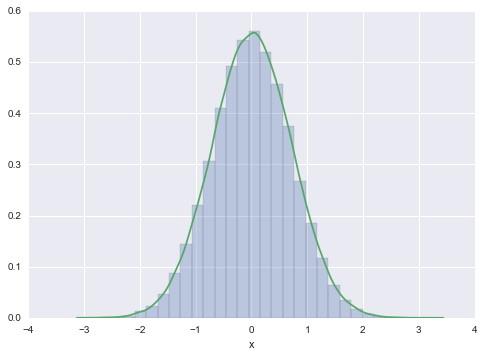

In [3]:
plt.hist(x, bins=30, alpha=0.3, normed=True);
sns.kdeplot(x)
plt.xlabel('x')

### Example 2

Suppose $p(x) = 3\,x^2$ from $0< x < 1$. We take $p(x,y) = 3x$  for 
$y < x < 1$ and $0 < y < x$ then the x-marginal is $p_X(x)=3x^2$. The two conditional densities are given by 

$$ p(y|x)  = \frac{1}{x}  \, \, \, \rm{for} \,\,\, 0 < y < x $$  
and 
$$ p(x|y)  = \frac{2x}{1-y^2}  \, \, \, \rm{for} \,\,\,y < x < 1 $$ 

Simulating from these conditionals is straightforward using inverse transformations. 

$$ Y|X = x  \,\, \sim x \, U $$ 

$$ X|Y = y  \,\, \sim \sqrt{ ( 1-y^2)\,U+y^2} $$

In [4]:
N=100000
x=np.zeros(N)
y=np.zeros(N)
x[0] = 0.1*np.random.rand()  #initial
for i in np.arange(1,N):
    y[i]=x[i-1]*np.random.rand()
    x[i]=np.sqrt((1-y[i]**2)*np.random.rand() + y[i]**2)

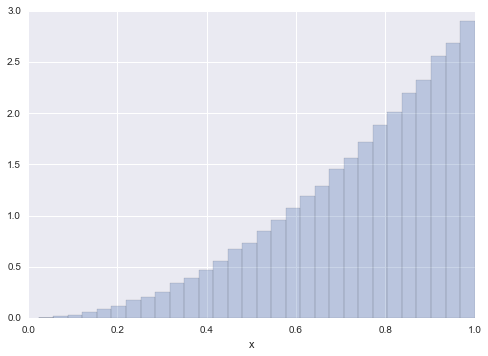

In [5]:
plt.hist(x, bins=30, alpha=0.3, normed=True);
plt.xlabel('x')

### Example 3

Suppose that $p(x)$ is a Student's t density with 4 degrees of freedom
$$ p(x) = \frac{3}{8} ( 1+ \frac{x^2}{4})^{-5/2} $$

If we take 

$$ p(x,y) = \frac{4}{\sqrt{2\pi}} y^{3/2} \exp{ \left\{  -y \left( \frac{x^2}{2}+2\right) \right\} } $$

for $0 < y < \infty$, 
then we can show that 

$$X|Y = y \,\,  \sim N(0, 1/y) $$ and that 
$$Y|X = x \,\, \sim \rm{Gamma}(5/2, x^2/2+2)$$



In [6]:
#We leave the implementation of this as an exercise

## Data Augmentation is a Markov Chain Monte Carlo

Now lets look at the DA closer. Let $p(y) = \int p(x,y) dx$.
Now lets define a function 

$$ k(x'|x) = \int_Y p(x'|y) \, p(y|x)\, dy $$

And since we are dealing with probability densities, $k$ is always positive.

Also note 

\begin{eqnarray}
  \int k(x'|x) dx' = \int_{X} \int_Y p(x'|y) \, p(y|x) \, dy \, dx' = \int_Y p(y|x) \left[ \int_X p(x'|y) dx' \right] dy  = \int_Y p(y|x) dy  = 1
  \end{eqnarray}
  
Therefore for each fixed $x$, $k(x'|x)$ is a nonnegative and integrates to 1. The function $k$ therefore
could be a Markov Chain transition density and if the current state is $x_n$ then the density of the next state 
is $k(.|x_n)$. 

Also  note that the $k(x'|x)\, p(x)$ is symmetric 
in $(x,x')$. 
 
$$ k(x'|x)\, p(x) = p(x) \int_Y p(x'|y) \, p(y|x) \, dy = \int_Y \frac{p(x',y)\, p(x,y) }{p(y)} \, dy. $$

The rhs is symmetric in  $(x,x')$ and so is $ k(x'|x) p(x)$. This also    implies that the Markov chain generated with transition probability $k(x'|x)$ is reversible.  

Integrating both sides with respect to x 

$$ \int_X k(x'|x)\, p(x) dx  = p(x') $$

This implies that when $X_0 \sim p(x)$ then $X_1$ is also $p(x)$. Actually
since $X$ is a time homogenous Markov chain, then 
$X_n\sim p(x)$ and $X_{n+1} \sim p(x)$. 


Now consider the practical issue of simulating the Markov chain $X$. Given that the current
state of the chain is $X_n = x$, how do we draw $X_{n+1}$ from the $k(.|x)$? The answer is
based on a sequential simulation technique that we now describe. 

Suppose we would like
to simulate a random vector from some pdf, $p_U(u)$, but we cannot do this directly. Suppose
further that $p_U$ is the u-marginal of the joint pdf $p_{U,V} (u, v)$ and that we have the ability to
make draws from $p_V(v)$ and from $p_{U,V} (u,v)$ for fixed $v$. If we draw $V\sim p_V(.)$, and then,
conditional on $V = v$, we draw $U \sim p_{U,V}(.|v)$, then the observed pair, $(u, v)$, is a draw from
$p_{U,V}$, which means that $u$ is a draw from $f_U$. We now can 
explain how it is used to simulate from $k(.|x)$.

Define 

$$ h(x',y| x) = p(x'|y) p(y|x) $$

We apply the procedure above with $k(.|x)$ and $h(.,.|x)$ playing the roles of 
$p_U(.)$ and $p_{U,V}(.,.)$ respectively. We of course need the marginal of
$h(x', y|x)$ which is $p(y|x)$ and the conditional density of $X'$ given $Y=y$  which is

$$ \frac{ h(x',y|x) }{p(y|x)} = p(x'|y) $$

which gives us the procedure above:

1. Draw $Y\sim p_{Y|X}(.|x)$ and call the observed value y
2. Draw $X_{n+1} \sim p_{X|Y}(.|y)$  

# Slice Sampling

#Introduction

We've already studied two MCMC variants, Gibbs Sampling and Metropolis-Hastings.  These are the foundational (and in many senses, original) MCMC methods.  Both methods are based on random walk Markov Chains.  You may have started to notice, or at least suspect, that there are many situation in which we want greater flexibity in exploring the probability space than waht a random walk Markov Chain provides.  There are a variety of MCMC methods that offer different approaches to traversing the distribution than Metropolis-Hastings (or Gibbs Sampling which is after all a type of Metropolis-Hastings).  We'll explore a number of these methods over the next few weeks.  

One of the methods that we'll look at is Slice Sampling.  Slice sampling was invented by Radfor Neal and John Skilling.  It is a very elegant and simple way to solve the problems of MH and Gibbs sampling. So easy, that you would think my grandmother invented it. Slice Sampling is geared to approach the following problem with Methropolis-Hastings.  Metropolis Hastings is very sensitive to the width of the proposal step.  You can tune the Metropolis-Hastings algorithm by choosing a proposal in such a way as to determine the width of the proposal distribution for each variable.  Unfortunately satisfying detailed-balance provides a constraint preventing any proposal width scale parameters from being set based on past iterations of the current chain.

One can set the proposal distribution width based on prior knowledge (usually done by running trial chains), but will often be confronted with the choice between a large width that explores the space efficiently but results in many rejections or a small proposal width that has a low rejection rate but explores the parameter space inefficiently. We usually want the width (aka step) to be as large as possible but not that large. Gibbs sampling does not have those parameters and therefore we may like it, but it only works when we know the conditional distribution. 






## How does slice sampling work?

If you recall from Data Augmentation, if we have a posterior distribution (i.e.  X ~ p(x) ) from which we're trying to sample, we can augment that distribution with additional variables to create a joint distribution p(x,y) with conditional distributions Y|X and X|Y that are easy to sample from.  We can use Gibbs to sample from these conditional distributions and keep the X samples while eventually discarding the Y samples that we don't need.

Slice sampling takes advantage of this same methodology to to try to efficiently sample from a distribution while dynamically adapting step-size to the local region it's sampling.  Let's take a look how.

### The General Univariate Slice Sampling Algorithm


0. Inititalize by randomly select $x^{(0)}$
1. Draw $y^{(k)} $ from $ U(0, f(x^{(k)})) $
2. Find an interval I = (L, R) around $ x^{k} $ corresponding to $ S = \{x\, s.t.\,  f(x) > f(x^{k}) \} $
3. Draw $ x^{(k+1)} $ from U(I)

Note, $S$ is the perfect region and $I$ is the interval we choose. 


In [7]:
mu1=3; mu2=10; sigma1=1; sigma2=2; l1=.0; l2=1.0;

normal = 1./np.sqrt(2*np.pi*sigma2**2)

fun=lambda x: l1*norm.pdf(x, mu1, sigma1)+l2*norm.pdf(x, mu2, sigma2)
invfunR=lambda y: np.sqrt(-2*sigma2**2*np.log(y/normal))+mu2
invfunL=lambda y: -np.sqrt(-2*sigma2**2*np.log(y/normal))+mu2
#print y0,invfunR(y0),invfunL(y0)

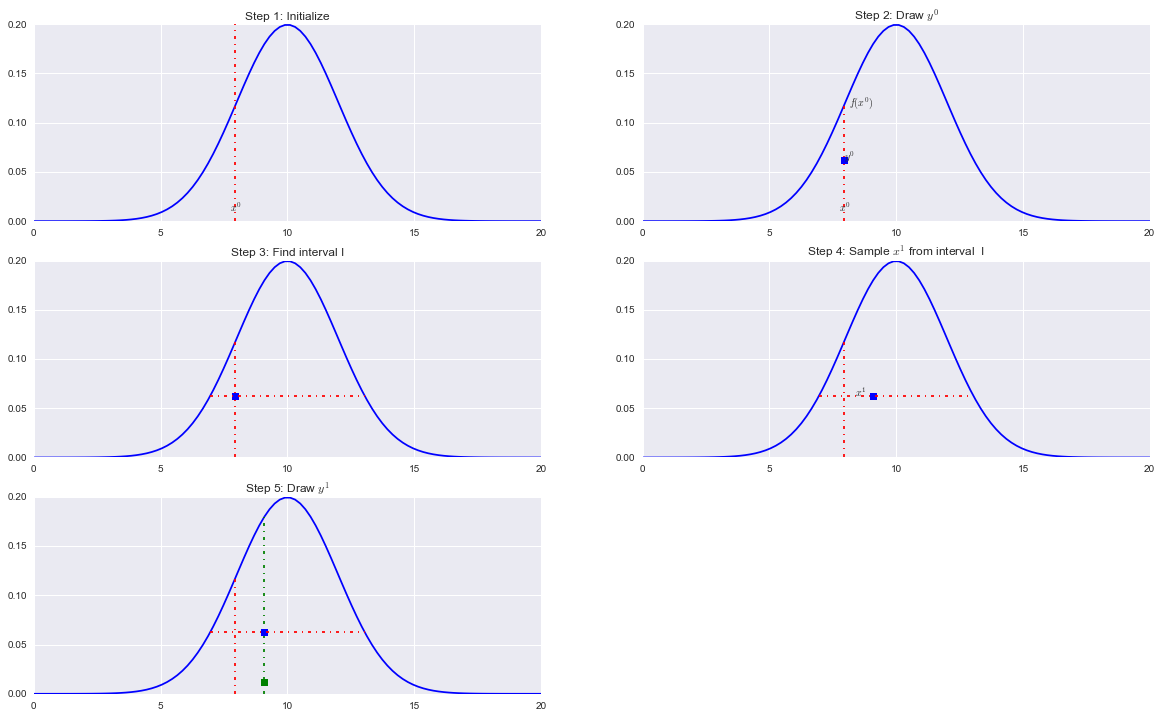

In [8]:
#sns.set()
x = np.linspace(0,20, 100)

plt.figure(figsize=[20,12])

plt.subplot(3,2,1)
plt.plot(x, fun(x), 'b')

np.random.seed(17)
x0=np.random.uniform(low=5, high=15, size=1)
plt.plot( [x0 ,x0], [0, 0.2], 'r-.')
plt.title('Step 1: Initialize')
plt.annotate( '$x^{0}$', [x0-0.2,.01], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)


plt.subplot(3,2,2)
plt.plot(x, fun(x), 'b')

plt.annotate( '$x^{0}$', [x0-0.2,.01], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)
plt.annotate( '$f(x^0)$', [x0+0.2, fun(x0)], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)



plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.title('Step 2: Draw $y^{0}$')
y0=np.random.uniform(low=0, high=fun(x0), size=1)
plt.plot( [x0,x0], [y0, y0], 'bs')

plt.annotate( '$y^{0}$', [x0,y0], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)

plt.subplot(3,2,3)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.plot( [x0,x0], [y0, y0], 'bs')


plt.plot( [invfunL(y0), invfunR(y0)] , [y0, y0], 'r-.')
#plt.plot( [2,4] , [y0, y0], 'r-.')
plt.title('Step 3: Find interval I') 

plt.subplot(3,2,4)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')

x1=np.random.uniform(low=8.5, high=11.5, size=1)
plt.plot( [x1,x1], [y0, y0], 'bs')
plt.plot( [invfunL(y0), invfunR(y0)] , [y0, y0], 'r-.')
#plt.plot( [2,4] , [y0, y0], 'r-.')
plt.title('Step 4: Sample $x^{1}$ from interval  I') 
plt.annotate( '$x^{1}$', [x1-0.7,y0], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)


plt.subplot(3,2,5)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.plot( [x1 ,x1], [0, fun(x1)], 'g-.')
y1=np.random.uniform(low=0, high=fun(x1), size=1)

plt.plot( [x1,x1], [y0, y0], 'bs')
plt.plot( [x1,x1], [y1, y1], 'gs')
plt.plot( [invfunL(y0), invfunR(y0)] , [y0, y0], 'r-.')
#plt.plot( [2,4] , [y0, y0], 'r-.')
plt.title('Step 5: Draw $y^1$') 
#plt.annotate( '$x^{1}$', [9.5,y0], xytext=None, xycoords='data',
#         textcoords='data', arrowprops=None)



This is workable assuming we can find the interval $I$. What about the multimodal case ? 

In [9]:
mu1=3; mu2=10; sigma1=1; sigma2=2; l1=.20; l2=.70;

normal = 1./np.sqrt(2*np.pi*sigma2**2)

fun=lambda x: l1*norm.pdf(x, mu1, sigma1)+l2*norm.pdf(x, mu2, sigma2)

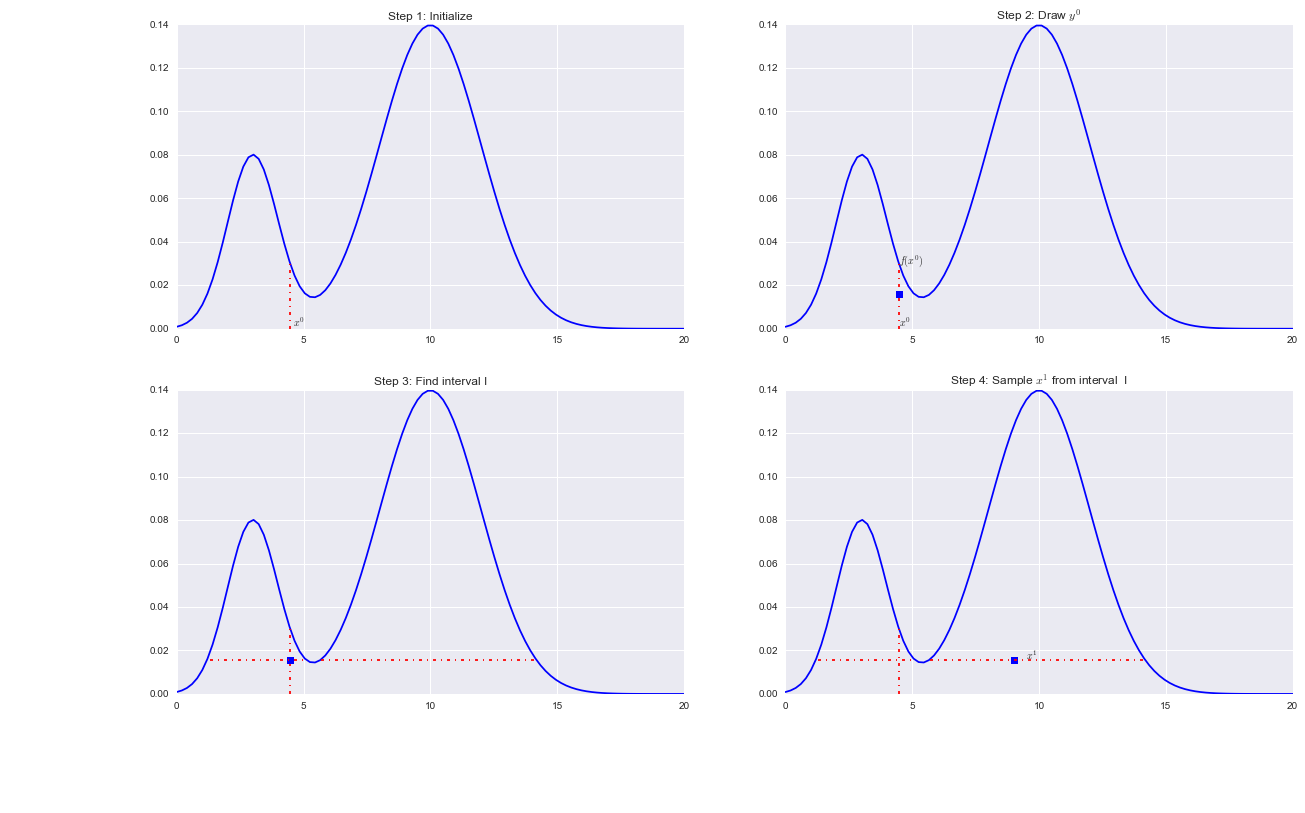

In [10]:
sns.set()
x = np.linspace(0,20, 100)

plt.figure(figsize=[20,12])

plt.subplot(2,2,1)
plt.plot(x, fun(x), 'b')

np.random.seed(16)
x0=np.random.uniform(low=0, high=20, size=1)
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.title('Step 1: Initialize')
plt.annotate( '$x^{0}$', [x0+0.1,.001], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)


plt.subplot(2,2,2)
plt.plot(x, fun(x), 'b')

plt.annotate( '$x^{0}$', [x0,.001], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)
plt.annotate( '$f(x^0)$', [x0,fun(x0)], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)



plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.title('Step 2: Draw $y^{0}$')
y0=np.random.uniform(low=0, high=fun(x0), size=1)
plt.plot( [x0,x0], [y0, y0], 'bs')

plt.annotate( '$y^{0}$', [10.5,.15], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)

plt.subplot(2,2,3)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.plot( [x0,x0], [y0, y0], 'bs')
plt.plot( [5.7,14.2] , [y0, y0], 'r-.')
plt.plot( [1.3,5.1] , [y0, y0], 'r-.')
plt.title('Step 3: Find interval I') 

plt.subplot(2,2,4)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.plot( [9,9], [y0, y0], 'bs')
plt.plot( [5.7,14.2] , [y0, y0], 'r-.')
plt.plot( [1.3,5.1] , [y0, y0], 'r-.')
plt.title('Step 4: Sample $x^{1}$ from interval  I') 
plt.annotate( '$x^{1}$', [9.5,y0], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)


The difficulty lies in steps 3 and 4.  If you know the inverse of f(x) then you could set  L = inf(S) (lower bound) and R = sup(S) (upper bound) as it is done in the unimodal example abpove. However in practice finding this region is not easy and there are various ways to do steps 3 and 4.

### Methods to Select the Univariate Window

There are a few different methods in the univariate case to select the Interval in Step 3 of the general procedure.  

1. Find the ideal bounds as described above in unimodal case 
2. If the range of $f(x)$ is bounded, then set the bounds of $f$ as your interval (L, R), draw $x$ from this interval and then reject/accept if it is below or above $f(x)$. 
3. A procedure known as "Stepping Out" and 
4. A procedure referred to as "Doubling."

1) and 2) are usually infeasible for different reasons.  1) is infeasible because it's in general not easy to find the inf and sup of arbitrary regions of f(x).  2) is infeasible because in many cases the region S is much smaller than the bounded range of f(x) and sampling uniformly from the range of f(x) would be an inefficient way to sample from I.  Let's concentrate on the other two methods.  

#### Reject/accept sampling

In [ ]:
x = np.linspace(0,20, 100)


# number of samples 
n=50000

vk=4

# randomly select x0
x_prev = np.random.uniform(low=0, high=17)

print x_prev
xsmp=[]

for k in np.arange(0,n):
    
    
    
    if k<vk:
        fig=plt.figure()
        fig=plt.plot(x, fun(x))
        fig=plt.plot( [x_prev ,x_prev], [0, fun(x_prev)], 'r-.')
   
    y_next = np.random.uniform(low=0, high=fun(x_prev)) 
    
   
    
    # NOW SAMPLE FROM ANYWHERE ON THE GREEN LINE 
    x_prop= np.random.uniform(low=0, high=20)
    
    if k<vk:
        fig=plt.plot( [x_prev,x_prev], [y_next, y_next], 'ks')
        fig=plt.plot( [0,20], [y_next, y_next])
        fig=plt.plot( [x_prop, x_prop], [y_next, y_next], 'bs')
        #plt.title("Ising Model: {} Iterations".format(sample + 1))
    
    
        display.clear_output()
        display.display(plt.gcf())
    
    
    
    if k<vk:
        print raw_input('May I continue your majesty? ')
    
    # ACCEPT REJECT 
    if y_next <=fun(x_prop):
        if k<vk: fig=plt.plot( [x_prop, x_prop], [y_next, y_next], 'ro', ms=13)
        x_prev = x_prop
        xsmp.append(x_prop)
    else:
        if k<vk: fig=plt.plot( [x_prop, x_prop], [y_next, y_next], 'ko', ms=12)
    
    

    if k<vk:
        display.clear_output()
        display.display(plt.gcf())
        print raw_input('May I continue your majesty2? ')
        plt.close()
    
#

In [ ]:
plt.hist(xsmp,bins=50, alpha=0.3, normed=True);
#sns.kdeplot(xsmp)
plt.xlim( [0,20])
plt.plot(x, fun(x))

print len(xsmp)

#### Stepping Out
The idea behind stepping out is that you expand your interval by fixed widths $w$ until your endpoints are outside of S.  The full algorithm is as follows:

* Set w = width of your interval expansions 
* draw u, v ~ Unif(0,1)
* set L = $ x^{(0)}  - w u, R = L + w$  (so $ x^{(0)} $ lies in [L, R] )
* while  y < f(L) (here's where we extend left interval)
   * L = L - w
* while y < f(R) ( here's where we extend the right interval)
   * R = R + w

The final interval will be larger than $S$. We will later see how we accept/reject to ensure our samples are from within $S$. 

In [ ]:
## STEPPING OUT EXAMPLE 
w=1.0

x = np.linspace(0,20, 100)
vk=1
L=0; R=0;
# number of samples 
n=5000
0
0

# randomly select x0
x_prev = np.random.uniform(low=0, high=17)

print x_prev
xsmp=[]

for k in np.arange(0,n):
    
    
    
    if k<vk:
        fig=plt.figure()
        fig=plt.plot(x, fun(x))
        fig=plt.plot( [x_prev ,x_prev], [0, fun(x_prev)], 'r-.')
   
    y_next = np.random.uniform(low=0, high=fun(x_prev)) 
    
   
    
    # NOW SAMPLE FROM ANYWHERE ON THE GREEN LINE 
    # STEPPING OUT 
    if k<vk:
        fig=plt.plot( [x_prev,x_prev], [y_next, y_next], 'ks')
        
    q=0
    L=x_prev-w/2.0; R=x_prev+w/2.0
    while fun(x_prev-q*w)>y_next:
        q +=1
        L = x_prev-q*w

        if k<vk: fig=plt.plot( [L,R], [y_next, y_next], 'r.')
        if k<vk: display.clear_output()
        if k<vk: display.display(plt.gcf())

        if k<vk:print raw_input('May I continue your majesty0a?')
    q=0
    R=x_prev+w/2.0
    while fun(x_prev+q*w)>y_next:
        q +=1
        R = x_prev+q*w

        if k<vk: fig=plt.plot( [L,R], [y_next, y_next], 'r.')
        if k<vk: display.clear_output()
        if k<vk: display.display(plt.gcf())

        if k<vk: print raw_input('May I continue your majesty0b?')
    
    x_prop= np.random.uniform(low=L, high=R)
    
    if k<vk:
       
        fig=plt.plot( [x_prop, x_prop], [y_next, y_next], 'bs')
        #plt.title("Ising Model: {} Iterations".format(sample + 1))
    
    
        display.clear_output()
        display.display(plt.gcf())
    
    
    
    if k<vk:
        print raw_input('May I continue your majesty? ')
    
    
    if y_next <fun(x_prop):
        if k<vk: fig=plt.plot( [x_prop, x_prop], [y_next, y_next], 'ro', ms=13)
        x_prev = x_prop
        xsmp.append(x_prop)
    else:
        if k<vk: fig=plt.plot( [x_prop, x_prop], [y_next, y_next], 'ko', ms=12)
    
    

    if k<vk:
        display.clear_output()
        display.display(plt.gcf())
        print raw_input('May I continue your majesty2? ')
        plt.close()
    
#

In [ ]:
plt.hist(xsmp,bins=50, alpha=0.3, normed=True);
#sns.kdeplot(xsmp)
plt.xlim( [0,20])
plt.plot(x, fun(x))

print len(xsmp)
#plt.acorr(xsmp-np.mean(xsmp))

#### Doubling
The idea behind doubling is that you expand your interval by doubling it's current length until endpoints are outside of S.  The full algorithm is as follows:

* Set w = width of your initial interval
* draw u  ~ Unif(0,1)
* set L = $ x_0 - w \, u, R = L + w $ (so $ x_0 $ lies in [L, R] )

* until { y > f(R) and y > f(L) }  ( here's where we extend the interval by doubling)
   * flip a coin 
   * if heads then L = L - (R - L) otherwise R = R + (R - L)




Note that we double the length by adding a segment of the same size as our current size randomly to either the L or R endpoint.  We do this regardless of whether that endpoint is already outside of S. We only stop when both sides are outside $S$. 

### Methods to Sample from the Univariate Window

#### Acceptible Proposals
Once we've obtained our interval $I$, we want to sample from it.  However as constructed $I$ is likely to be larger than the actual set of acceptable proposals.  What are the set of acceptable proposals?  They have to satisfy the following criteria:

1.  They lie within $I$
2.  They lie within $S$
3.  They satisfy detail balance
  * Let's call our current sample $ x^{(0)} $
  * Let's call a possible proposal  x* 
  * x* would be an acceptable proposal if $ x_0 $ would be an acceptable proposal for x* if x* were the current sample [PP:LETS REVISIT]

We can call our set of acceptable proposals for a given $ x_0, A$.  


#### Options
There are a few possible methods to sample from the interval.  

1. We can repeatedly sample from within $I$ until we obtain a point within $S$
2. We can try a procedure known as "shrinkage"
3. If we used the doubling procedure we need an alternative "shrinkage" procedure

Repeatedly sampling from within $I$ as in 1), may not be efficient (especially if $S$ is much smaller than $I$).  Let's then explore the "shrinkage" procedures.

####  Conventional Shrinkage Procedure

The idea behind the shrinkage procedure is that you sample from your interval, if the sample's not in $S$, make that point the new endpoint of your interval decreasing the length of your interval.  Otherwise keep the sample and go back to the interval selection problem.

* start with  interval $I = (L, R)$
* current sample is $ x^{(k)} $ and $y^{(k)}$
* repeat until loop exits
   * sample $x^{*}$ uniformly from (L, R)
   * if $y^{(k)}< f(x^{*})$
      * accept x* and end loop
   * else
      * if $x^{*} <  x^{(k)} \rightarrow  L = x^{*}$ 
      * if $x^{*} > x^{(k)} \rightarrow  R = x^{*}$ 

#### Shrinkage Procedure for Doubling
The conventional shrinkage procedure doesn't work for intervals $I$ generated by doubling because it's possible for a state to be within the intersection of $I$ and $S$ but not be an acceptable proposal.  So we need to create a special shrinkage procedure that weeds out unacceptable proposals:

* start with  interval $I = (L, R)$, current $X$ sample $ x_0 $ and $Y$ sample $y$
* proposal x*
* D = false, w = estimate of slice width
* repeat while (R-L) > 1.1*w
   * M = (R + L)/2
   * if ($x_0$ >= M and x* < M) or ($x_0$ < M and x* >= M) then D = true
   * if x* < M then R = M otherwise L = M
   * if y >= f(L) and y >= f(R) and D
* If the x* isn't rejected accept.


### Revisiting the Univariate Slice Sampling Algorithm

With all that background, our univariate slice sampling algorithm should be clear

* Pick an initial point $ x_0 $ from our posterior
* Draw $ y_0 $ from U(0, f($x_0$))
* Repeat for N samples
  * Select the interval (e.g. doubling, stepping out, etc)
  * Sample $ x_i $ from that interval (e.g. shrinkage)
  * Draw $ y_i $ from U(0, f($x_i$))

## Revisiting Data Augmentation

Let's look a bit more closely at Data Augmentation and it's relationship to Slice Sampling.  If you recall the exact procedure for data augmentation is as follows. 

You're given $ X $ from which you wish to sample.  Sampling from them is difficult but with the addition of some auxilliary variables $ Y $ you're able to sample from the joint probability p(X,Y) so that :

1.  the conditionals X|Y and Y|X are easy to sample 
2.  the marginal p(X) from the joint p(X,Y) matches your target distribution.
3.  You can then use Gibbs Sampling to generate samples for the joint distribution and keep the X samples 


Now let's look more closely at our slice sampling procedure.  

* We're given X
* We add an auxiliary variable Y 
* The marginals are easy to sample
   * Y|X ~ Unif(0,f(x))
   * X|Y = 1 if f(x) > y and 0 otherwise
* the marginal of X matches our target distribution by construction
* we use Gibbs sampling to generate our samples

IT's A DATA AUGMENTATION PROCEDURE!  The only difference is that we don't explicitly know our joint distribution.



## Multivariate Slice Sampling

On casual inspection it would seem that the slice sampling algorithm would generalize very easily to the multivariate case.  If we look at our general univariate algorithm:

0. Inititalize by randomly selecting $x^{(0)}$
1. Draw $y^{(k)} $ from $ U(0, f(x^{(k)})) $
2. Find an interval I = (L, R) around $ x^{k} $ corresponding to $ S = \{x\, s.t.\,  f(x) > f(x^{k}) \} $
3. Draw $ x^{k+1} $ from U(I)


A natural extension to $ R^n $ would be:

0. Inititalize by randomly selecting $\hat{x}^{(0)}$
1. Draw $y^{(k)} $ from $ U(0, f(x^{(k)})) $
2. Find a hyperrectangle K = $\{(L_1,R_1)\times \ldots \times(L_n, R_n)\}$ around $ \hat{x}^{k} $ corresponding to $ S = \{\hat{x}\, s.t.\,  f(\hat{x}) > f(\hat{x}^{k}) \} $
3. Draw $ \hat{x}^{k+1} $ uniformly from K

Step 1 is not difficult and generalizes easily.  Step 2 is difficult.  We ideally want the minimum hyperrectangle containing $ S $, but in practice this is just as (if not more) difficult as finding the ideal interval $I$ in the univariate case.  Moreover some of the techniques that we described in the univariate case have difficulties in the multivariate case.

* Stepping out is difficult because an $n$ dimensional hyperrectangle has $ 2^n $ vertices.  Checking individual vertices can be a computationally expensive problem.  In addition, stepping out individually in $n$ directions can be computationally expensive as well.

* Accept/reject on a global region (in the case where your distribution is bounded) is even less efficient in multiple dimensions than it is in one.

We outline a simple solution that gives up some of the natural advantages of univariate slice sampling but does solve some of the basic issues for multivariate slice sampling.  It depends on having some prior knowledge of the appropriate hyperectagle width in each dimension.

#### Hyperrectangle multivariate slices sample algorithm

* start with $ x^{k} $ and $\hat{w} $ -- the prior widths
* $ y^{k} \sim Unif(0,f(x^{k})) $
* for $ i = 1 \ldots n $ (setting hyperrectangle around $ x^{k} $)
   * $ u_i \sim Unif(0,1) $
   * $ L_i = x^{k}_i - w_i u_i $
   * $ R_i = L_i + w_i $
* loop until:
   * for $ i = 1 \ldots n $ 
      * $ u_i \sim Unif(0,1) $
      * $ x^{*}_i = Unif(L_i, R_i) $
   * if $y^{(k)}< f(x^{*})$
      * accept x* and end loop
   * else
      * for $ i = 1 \ldots n$
         * if $x^{*}_i <  x^{(k)}_i \rightarrow  L_i = x^{*}_i$ 
         * if $x^{*}_i > x^{(k)}_i \rightarrow  R_i = x^{*}_i$
         

It should be noted that because we don't use a method like doubling or setting out, we gain an increased sensitivity to step-size (via our dependence on the width vector $ \hat{w} $ and lose part of the advantage slice sampling held over Metropolis-Hastings.  Width is now a tunable parameter.

In [ ]:
def mvslice(pdf, x0, widths, sampleSize=1000, dims=2, burnin=0, thin=0):

    """

    :param pdf:  function we're trying to sample
    :param x0:   inital point
    :param widths:  prior for widths of our hyperrectangle
    :param sampleSize:  number of samples to generate
    :param dims:  dimension of our multivariate space
    :param burnin:  number of samples to get rid of at beginning
    :param thin:   number of samples to keep
    """
    y0 = np.random.uniform(low=0, high=pdf(x0))
    samples = []

    # get hyperrectangle
    rectUnifs = np.random.uniform(size=dims)
    rectLefts = x0 - widths*rectUnifs
    rectRights = rectLefts + widths

    # Get our samples
    for i in range(sampleSize):

        while (True):

            # new proposal
            xstarUnifs = np.random.uniform(size=dims)
            xstar = rectLefts + xstarUnifs*(rectRights - rectLefts)

            if y0 < pdf(xstar):
                break
            else:

                # update rectangle
                for j in range(dims):

                    if xstar[j] < x0[j]:
                        rectLefts[j] = xstar[j]
                    else:
                        rectRights[j] = xstar[j]


        # save our sample
        samples.append(xstar)

        # Our last sample x0 is now our proposal
        x0 = xstar

        # Get our new y0 for next step
        y0 = np.random.uniform(low=0, high=pdf(x0))

        # reset our rectangle
        rectLefts = x0 - widths*rectUnifs
        rectRights = rectLefts + widths

    return samples

pdf = lambda x: np.e**(-(x[0]**2)/2 - ((-x[1])**2)/2)
X = np.array(mvslice(pdf,[0,0], [10,10], sampleSize=10000))
Xs = [a[1] for a in X]
Ys = [a[0] for a in X]

sns.kdeplot(X)